[View in Colaboratory](https://colab.research.google.com/github/joheras/CLoDSA/blob/master/notebooks/CLODSA_Plants.ipynb)

# Augmenting a dataset for object detection

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to object detection. In particular, we use the [Plant Phenotyping dataset for object detection](https://www.plant-phenotyping.org/datasets-home) - from now on we will call this dataset, the Plant dataset.

The Plant training dataset for object detection, presented in the paper ["Finely-grained annotated datasets for image-based plant phenotyping"](https://www.sciencedirect.com/science/article/pii/S0167865515003645#sec0007), consists of 70 tray images where plants can be arranged in a grid, either fixed in position in specialized trays or not and can even be touching each other, the latter leading to a non trivial detection problem. For illustration purposes, we take a subset of the Plant dataset containing 27 images. Such a subset can be downloaded by executing the following command. 

In [1]:
!wget https://www.dropbox.com/s/9mtp7x8lpvw7alt/Tray.zip?dl=0 -O Tray.zip
!unzip Tray.zip

--2019-06-29 10:48:24--  https://www.dropbox.com/s/9mtp7x8lpvw7alt/Tray.zip?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/9mtp7x8lpvw7alt/Tray.zip [siguiente]
--2019-06-29 10:48:41--  https://www.dropbox.com/s/raw/9mtp7x8lpvw7alt/Tray.zip
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc96cb06e15ac3427ab1ebeee994.dl.dropboxusercontent.com/cd/0/inline/AjuX4U8HeVd0qpCs3KJIXCzE4D-fJq6VD_Op5IRggNbI5EIwjRQujFbgPxdO0BeZsAKZhNlUyuX2JRbL1R5AjqddEa0WOv17RG7Ajv0bG06vCQ/file# [siguiente]
--2019-06-29 10:48:42--  https://uc96cb06e15ac3427ab1ebeee994.dl.dropboxusercontent.com/cd/0/inline/AjuX4U8HeVd0qpCs3KJIXCzE4D-fJq6VD_Op5IRggNbI5EIwjRQujFbgPxdO0BeZsAKZhNlUyuX2JRbL1R5AjqddEa0WOv17RG7Ajv0bG06vCQ/file
Resolvie

We can check the amount of images in each one of the folders.

In [2]:
print("Number of images in the folder")
!ls -1 Tray/Ara2013-Canon/*.png | wc -l

Number of images in the folder
27


## Preparing the dataset

Each image of the Plant dataset is annotated with a comma-separated value (CSV) file reporting for each plant the corner pixel coordinates of its bounding box. This format is not currently supported by the CLODSA library, so we provide a script that convert the CSV files to xml files following the [PASCAL VOC format](https://link.springer.com/article/10.1007/s11263-009-0275-4) - a common format employed in object detection problems and that is already supported by CLODSA.




In [3]:
!wget https://www.dropbox.com/s/tchi6u74q7whe2w/plants_script.py?dl=0 -O plants_script.py

--2019-06-29 10:50:58--  https://www.dropbox.com/s/tchi6u74q7whe2w/plants_script.py?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/tchi6u74q7whe2w/plants_script.py [siguiente]
--2019-06-29 10:50:59--  https://www.dropbox.com/s/raw/tchi6u74q7whe2w/plants_script.py
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc15660fd31a3c7539c6748e9300.dl.dropboxusercontent.com/cd/0/inline/AjvbCY_UVDYLe5PzIv9tKHCuq98YHPv8yxSDzCLxkNfMbEb2RMGS-uoTpaTDG45gbZ_qa7JH-AoJ_qqRYDhd3gEI4d_I9AYTtr5UuFTmL9xQeQ/file# [siguiente]
--2019-06-29 10:50:59--  https://uc15660fd31a3c7539c6748e9300.dl.dropboxusercontent.com/cd/0/inline/AjvbCY_UVDYLe5PzIv9tKHCuq98YHPv8yxSDzCLxkNfMbEb2RMGS-uoTpaTDG45gbZ_qa7JH-AoJ_qqRYDhd3gEI4d_I9AYTtr5U

In [4]:
!pip install imutils
!python plants_script.py

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Augmentation techniques

In this notebook, we will use the following augmentation techniques:
- Vertical, horizontal, and vertical-horizontal flips.
- 180º Rotation.
- Average blurring.
- Raise the hue value. 

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [5]:
!pip install clodsa

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA. We also load some libraries to show the results.

In [1]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

Using TensorFlow backend.


## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a detection problem

In [2]:
PROBLEM = "detection"

_The annotation mode_. We use the Pascal VOC format. 

In [3]:
ANNOTATION_MODE = "pascalvoc"

_The input path_. The input path containing the images. 

In [4]:
INPUT_PATH = "Tray/Ara2013-Canon/"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [5]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images.  

In [6]:
OUTPUT_MODE = "pascalvoc"
OUTPUT_PATH= "Tray/Ara2013-Canon"

Using the above information, we can create our augmentor object. 

In [7]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



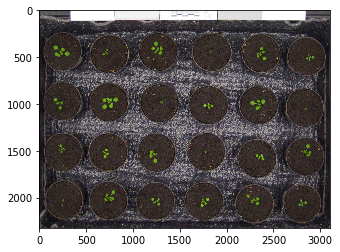

In [8]:
img = cv2.imread("Tray/Ara2013-Canon/ara2013_tray05_rgb.png")
# changing to the BGR format of OpenCV to RGB format for matplotlib
plt.imshow(img[:,:,::-1])

Just for showing the results of applying data augmentation in an object detection problem, we define a function to read the annotations and another one to show them. This funcionality is not necessary when using CLODSA since it is already implemented in there. 

In [9]:
def boxesFromPascalVOC(labelPath):
    tree = ET.parse(labelPath)
    root = tree.getroot()
    objects = root.findall('object')
    if(len(objects)<1):
        raise Exception("The xml should contain at least one object")
    boxes = []
    for object in objects:
        category = object.find('name').text
        bndbox = object.find('bndbox')
        x  = int(bndbox.find('xmin').text)
        y = int(bndbox.find('ymin').text)
        h = int(bndbox.find('ymax').text)-y
        w = int(bndbox.find('xmax').text) - x
        boxes.append((category, (x, y, w, h)))
    return boxes

In [10]:
def showBoxes(image,boxes):
    cloneImg = image.copy()
    for box in boxes:
        if(len(box)==2):
            (category,(x,y,w,h)) = box
        else:
            (category,(x,y,w,h),_) = box
        cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(255,0,0),15)
    plt.imshow(cloneImg[:,:,::-1])
    

Now, we show the annotation of the image.

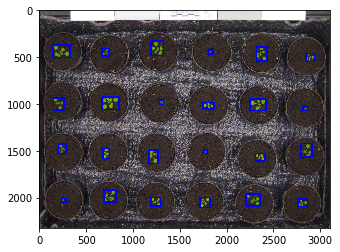

In [11]:
boxes = boxesFromPascalVOC("Tray/Ara2013-Canon/ara2013_tray05_rgb.xml")
showBoxes(img,boxes)

First of all, we must define a transformer generator.

In [12]:
transformer = transformerGenerator(PROBLEM)

#### Vertical flip

In [13]:
vFlip = createTechnique("flip",{"flip":0})
augmentor.addTransformer(transformer(vFlip))

Showing the result of applying the transformation.

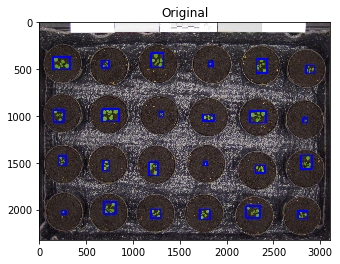

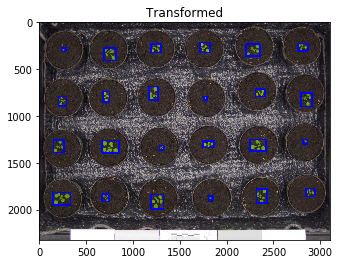

In [14]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
vFlipGenerator = transformer(vFlip)
vFlipImg,vFlipBoxes = vFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(vFlipImg,vFlipBoxes)

#### Horizontal flip

In [15]:
hFlip = createTechnique("flip",{"flip":1})
augmentor.addTransformer(transformer(hFlip))

Showing the result of applying the transformation.

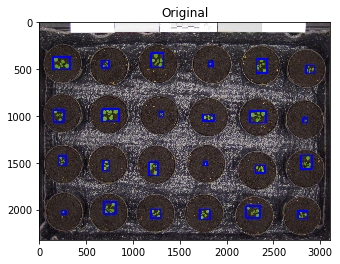

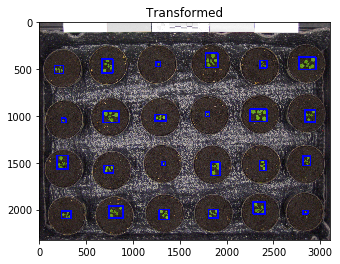

In [16]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hFlipGenerator = transformer(hFlip)
hFlipImg,hFlipBoxes = hFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hFlipImg,hFlipBoxes)

#### Horizontal and vertical flip

In [17]:
hvFlip = createTechnique("flip",{"flip":-1})
augmentor.addTransformer(transformer(hvFlip))

Showing the result of applying the transformation.

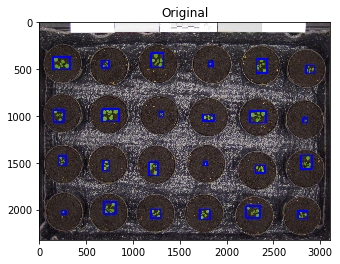

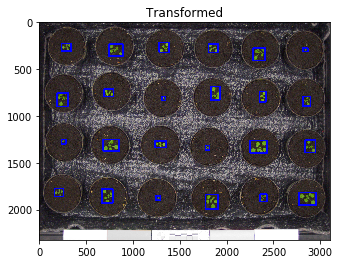

In [18]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hvFlipGenerator = transformer(hvFlip)
hvFlipImg,hvFlipBoxes = hvFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hvFlipImg,hvFlipBoxes)

#### Rotation:

In [19]:
rotate = createTechnique("rotate", {"angle" : 90})
augmentor.addTransformer(transformer(rotate))

Showing the result of applying the transformation.

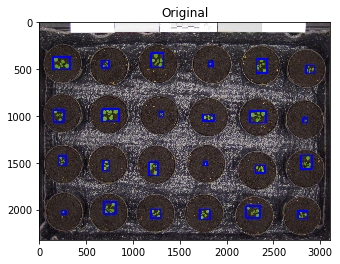

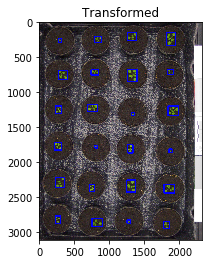

In [20]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
rotateGenerator = transformer(rotate)
rotateImg,rotateBoxes = rotateGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(rotateImg,rotateBoxes)

#### Average blurring

In [21]:
avgBlur =  createTechnique("average_blurring", {"kernel" : 5})
augmentor.addTransformer(transformer(avgBlur))

Showing the result of applying the transformation.

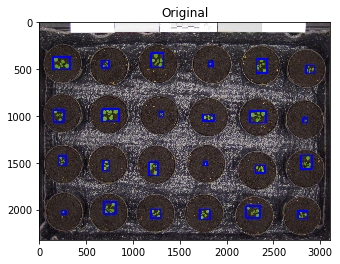

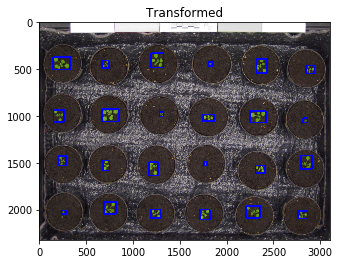

In [22]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
avgBlurGenerator = transformer(avgBlur)
avgBlurImg,avgBlurBoxes = avgBlurGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(avgBlurImg,avgBlurBoxes)

#### Raise Hue

In [23]:
hue = createTechnique("raise_hue", {"power" : 0.9})
augmentor.addTransformer(transformer(hue))

Showing the result of applying the transformation.

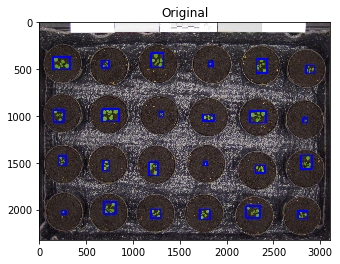

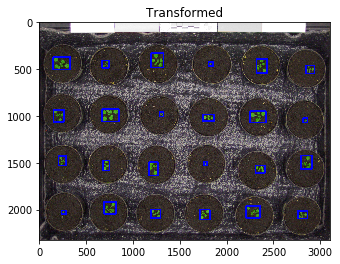

In [24]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hueGenerator = transformer(hue)
hueImg,hueBoxes = hueGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hueImg,hueBoxes)

#### None
(to keep also the original image)

In [27]:
none = createTechnique("none",{})
augmentor.addTransformer(transformer(none))

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [28]:
augmentor.applyAugmentation()

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f33c0b9c8a0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/jonathan/.virtualenvs/cv/lib/python3.6/sit...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/jonath.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f33c0b9c8a0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/jonathan/.virtualenvs/cv/lib/python3.6/sit...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/jonath.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    500         if self.poller is not None:
    501             self.poller.start()
    502         self.kernel.start()
    503         self.io_loop = ioloop.IOLoop.current()
    504         try:
--> 505             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    506         except KeyboardInterrupt:
    507             pass
    508 
    509 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/usr/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    422             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    423                                    finalizer=self._asyncgen_finalizer_hook)
    424         try:
    425             events._set_running_loop(self)
    426             while True:
--> 427                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    428                 if self._stopping:
    429                     break
    430         finally:
    431             self._stopping = False

...........................................................................
/usr/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1435                         logger.warning('Executing %s took %.3f seconds',
   1436                                        _format_handle(handle), dt)
   1437                 finally:
   1438                     self._current_handle = None
   1439             else:
-> 1440                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...c80>, ...]))>))>>
   1441         handle = None  # Needed to break cycles when an exception occurs.
   1442 
   1443     def _set_coroutine_wrapper(self, enabled):
   1444         try:

...........................................................................
/usr/lib/python3.6/asyncio/events.py in _run(self=<Handle IOLoop._run_callback(functools.par...c80>, ...]))>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_w...850bc8>, <zmq.sugar.fr...x7f33b4850c80>, ...]))>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_w...850bc8>, <zmq.sugar.fr...x7f33b4850c80>, ...]))>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_w...850bc8>, <zmq.sugar.fr...x7f33b4850c80>, ...]))>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<Future finished result=(10, 33, <bound method.....4850bc8>, <zmq.sugar.fr...x7f33b4850c80>, ...]))>,), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<Future finished result=(10, 33, <bound method.....4850bc8>, <zmq.sugar.fr...x7f33b4850c80>, ...]))>,)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/gen.py in inner(f=None)
   1228             return False
   1229         elif not self.future.done():
   1230             def inner(f):
   1231                 # Break a reference cycle to speed GC.
   1232                 f = None  # noqa
-> 1233                 self.run()
   1234             self.io_loop.add_future(
   1235                 self.future, inner)
   1236             return False
   1237         return True

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/gen.py in run(self=<tornado.gen.Runner object>)
   1142                         finally:
   1143                             # Break up a reference to itself
   1144                             # for faster GC on CPython.
   1145                             exc_info = None
   1146                     else:
-> 1147                         yielded = self.gen.send(value)
        yielded = undefined
        self.gen.send = <built-in method send of generator object>
        value = (10, 33, <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>, (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]))
   1148 
   1149                     if stack_context._state.contexts is not orig_stack_contexts:
   1150                         self.gen.throw(
   1151                             stack_context.StackContextInconsistentError(

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    352         else:
    353             try:
    354                 priority, t, dispatch, args = self.msg_queue.get_nowait()
    355             except QueueEmpty:
    356                 return None
--> 357         yield gen.maybe_future(dispatch(*args))
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    358 
    359     @gen.coroutine
    360     def dispatch_queue(self):
    361         """Coroutine to preserve order of message handling

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object dispatch_shell>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'augmentor.applyAugmentation()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 29, 8, 58, 22, 56745, tzinfo=tzutc()), 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'session': 'f47477f1704d494689fe22dea3e1ed18', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'parent_header': {}})
    262             try:
    263                 self.pre_handler_hook()
    264             except Exception:
    265                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    266             try:
--> 267                 yield gen.maybe_future(handler(stream, idents, msg))
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f47477f1704d494689fe22dea3e1ed18']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'augmentor.applyAugmentation()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 29, 8, 58, 22, 56745, tzinfo=tzutc()), 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'session': 'f47477f1704d494689fe22dea3e1ed18', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'parent_header': {}}
    268             except Exception:
    269                 self.log.error("Exception in message handler:", exc_info=True)
    270             finally:
    271                 try:

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [b'f47477f1704d494689fe22dea3e1ed18'], {'buffers': [], 'content': {'allow_stdin': True, 'code': 'augmentor.applyAugmentation()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 29, 8, 58, 22, 56745, tzinfo=tzutc()), 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'session': 'f47477f1704d494689fe22dea3e1ed18', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'parent_header': {}}), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object execute_request>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f47477f1704d494689fe22dea3e1ed18'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'augmentor.applyAugmentation()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 29, 8, 58, 22, 56745, tzinfo=tzutc()), 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'session': 'f47477f1704d494689fe22dea3e1ed18', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '67fd0b887d59433cbb00e66947f4fd65', 'msg_type': 'execute_request', 'parent_header': {}})
    529             self._publish_execute_input(code, parent, self.execution_count)
    530 
    531         reply_content = yield gen.maybe_future(
    532             self.do_execute(
    533                 code, silent, store_history,
--> 534                 user_expressions, allow_stdin,
        user_expressions = {}
        allow_stdin = True
    535             )
    536         )
    537 
    538         # Flush output before sending the reply.

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/tornado/gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, 'augmentor.applyAugmentation()', False, True, {}, True), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object do_execute>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='augmentor.applyAugmentation()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    289                     res = yield coro_future
    290             else:
    291                 # runner isn't already running,
    292                 # make synchronous call,
    293                 # letting shell dispatch to loop runners
--> 294                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = 'augmentor.applyAugmentation()'
        store_history = True
        silent = False
    295         finally:
    296             self._restore_input()
    297 
    298         if res.error_before_exec is not None:

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('augmentor.applyAugmentation()',), **kwargs={'silent': False, 'store_history': True})
    531             )
    532         self.payload_manager.write_payload(payload)
    533 
    534     def run_cell(self, *args, **kwargs):
    535         self._last_traceback = None
--> 536         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('augmentor.applyAugmentation()',)
        kwargs = {'silent': False, 'store_history': True}
    537 
    538     def _showtraceback(self, etype, evalue, stb):
    539         # try to preserve ordering of tracebacks and print statements
    540         sys.stdout.flush()

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='augmentor.applyAugmentation()', store_history=True, silent=False, shell_futures=True)
   2814         result : :class:`ExecutionResult`
   2815         """
   2816         result = None
   2817         try:
   2818             result = self._run_cell(
-> 2819                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'augmentor.applyAugmentation()'
        store_history = True
        silent = False
        shell_futures = True
   2820         finally:
   2821             self.events.trigger('post_execute')
   2822             if not silent:
   2823                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='augmentor.applyAugmentation()', store_history=True, silent=False, shell_futures=True)
   2840             runner = self.loop_runner
   2841         else:
   2842             runner = _pseudo_sync_runner
   2843 
   2844         try:
-> 2845             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <generator object InteractiveShell.run_cell_async>
   2846         except BaseException as e:
   2847             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2848             result = ExecutionResult(info)
   2849             result.error_in_exec = e

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/async_helpers.py in _pseudo_sync_runner(coro=<generator object InteractiveShell.run_cell_async>)
     62 
     63     Credit to Nathaniel Smith
     64 
     65     """
     66     try:
---> 67         coro.send(None)
        coro.send = <built-in method send of generator object>
     68     except StopIteration as exc:
     69         return exc.value
     70     else:
     71         # TODO: do not raise but return an execution result with the right info.

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='augmentor.applyAugmentation()', store_history=True, silent=False, shell_futures=True)
   3015                 interactivity = "none" if silent else self.ast_node_interactivity
   3016                 if _run_async:
   3017                     interactivity = 'async'
   3018 
   3019                 has_raised = yield from self.run_ast_nodes(code_ast.body, cell_name,
-> 3020                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3021 
   3022                 self.last_execution_succeeded = not has_raised
   3023                 self.last_execution_result = result
   3024 

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-28-1d9c8eaf67b6>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f335841b6a0, executi...rue silent=False shell_futures=True> result=None>)
   3186                         return True
   3187 
   3188                 for i, node in enumerate(to_run_interactive):
   3189                     mod = ast.Interactive([node])
   3190                     code = compiler(mod, cell_name, "single")
-> 3191                     if (yield from self.run_code(code, result)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f33584eec90, file "<ipython-input-28-1d9c8eaf67b6>", line 1>
        result = <ExecutionResult object at 7f335841b6a0, executi...rue silent=False shell_futures=True> result=None>
   3192                         return True
   3193 
   3194             # Flush softspace
   3195             if softspace(sys.stdout, 0):

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f33584eec90, file "<ipython-input-28-1d9c8eaf67b6>", line 1>, result=<ExecutionResult object at 7f335841b6a0, executi...rue silent=False shell_futures=True> result=None>, async_=False)
   3262                 if async_:
   3263                     last_expr = (yield from self._async_exec(code_obj, self.user_ns))
   3264                     code = compile('last_expr', 'fake', "single")
   3265                     exec(code, {'last_expr': last_expr})
   3266                 else:
-> 3267                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f33584eec90, file "<ipython-input-28-1d9c8eaf67b6>", line 1>
        self.user_global_ns = {'ANNOTATION_MODE': 'pascalvoc', 'ET': <module 'xml.etree.ElementTree' from '/usr/lib/python3.6/xml/etree/ElementTree.py'>, 'GENERATION_MODE': 'linear', 'INPUT_PATH': 'Tray/Ara2013-Canon/', 'In': ['', "from matplotlib import pyplot as plt\nfrom clodsa..._ipython().run_line_magic('matplotlib', 'inline')", 'PROBLEM = "detection"', 'ANNOTATION_MODE = "pascalvoc"', 'INPUT_PATH = "Tray/Ara2013-Canon/"', 'GENERATION_MODE = "linear"', 'OUTPUT_MODE = "pascalvoc"\nOUTPUT_PATH= "Tray/Ara2013-Canon"', 'augmentor = createAugmentor(PROBLEM,ANNOTATION_M...ATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})', 'img = cv2.imread("Tray/Ara2013-Canon/ara2013_tra...B format for matplotlib\nplt.imshow(img[:,:,::-1])', 'def boxesFromPascalVOC(labelPath):\n    tree = ET...append((category, (x, y, w, h)))\n    return boxes', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'boxes = boxesFromPascalVOC("Tray/Ara2013-Canon/ara2013_tray05_rgb.xml")\nshowBoxes(img,boxes)', 'transformer = transformerGenerator(PROBLEM)', 'vFlip = createTechnique("flip",{"flip":0})\naugmentor.addTransformer(transformer(vFlip))', 'plt.figure()\nplt.title("Original")\nshowBoxes(img...tle("Transformed")\nshowBoxes(vFlipImg,vFlipBoxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'plt.figure()\nplt.title("Original")\nshowBoxes(img...tle("Transformed")\nshowBoxes(vFlipImg,vFlipBoxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'boxes = boxesFromPascalVOC("Tray/Ara2013-Canon/ara2013_tray05_rgb.xml")\nshowBoxes(img,boxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', ...], 'OUTPUT_MODE': 'pascalvoc', 'OUTPUT_PATH': 'Tray/Ara2013-Canon', 'Out': {8: <matplotlib.image.AxesImage object>}, 'PROBLEM': 'detection', '_': <matplotlib.image.AxesImage object>, ...}
        self.user_ns = {'ANNOTATION_MODE': 'pascalvoc', 'ET': <module 'xml.etree.ElementTree' from '/usr/lib/python3.6/xml/etree/ElementTree.py'>, 'GENERATION_MODE': 'linear', 'INPUT_PATH': 'Tray/Ara2013-Canon/', 'In': ['', "from matplotlib import pyplot as plt\nfrom clodsa..._ipython().run_line_magic('matplotlib', 'inline')", 'PROBLEM = "detection"', 'ANNOTATION_MODE = "pascalvoc"', 'INPUT_PATH = "Tray/Ara2013-Canon/"', 'GENERATION_MODE = "linear"', 'OUTPUT_MODE = "pascalvoc"\nOUTPUT_PATH= "Tray/Ara2013-Canon"', 'augmentor = createAugmentor(PROBLEM,ANNOTATION_M...ATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})', 'img = cv2.imread("Tray/Ara2013-Canon/ara2013_tra...B format for matplotlib\nplt.imshow(img[:,:,::-1])', 'def boxesFromPascalVOC(labelPath):\n    tree = ET...append((category, (x, y, w, h)))\n    return boxes', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'boxes = boxesFromPascalVOC("Tray/Ara2013-Canon/ara2013_tray05_rgb.xml")\nshowBoxes(img,boxes)', 'transformer = transformerGenerator(PROBLEM)', 'vFlip = createTechnique("flip",{"flip":0})\naugmentor.addTransformer(transformer(vFlip))', 'plt.figure()\nplt.title("Original")\nshowBoxes(img...tle("Transformed")\nshowBoxes(vFlipImg,vFlipBoxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'plt.figure()\nplt.title("Original")\nshowBoxes(img...tle("Transformed")\nshowBoxes(vFlipImg,vFlipBoxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', 'boxes = boxesFromPascalVOC("Tray/Ara2013-Canon/ara2013_tray05_rgb.xml")\nshowBoxes(img,boxes)', 'def showBoxes(image,boxes):\n    cloneImg = image...,0,0),15)\n    plt.imshow(cloneImg[:,:,::-1])\n    ', ...], 'OUTPUT_MODE': 'pascalvoc', 'OUTPUT_PATH': 'Tray/Ara2013-Canon', 'Out': {8: <matplotlib.image.AxesImage object>}, 'PROBLEM': 'detection', '_': <matplotlib.image.AxesImage object>, ...}
   3268             finally:
   3269                 # Reset our crash handler in place
   3270                 sys.excepthook = old_excepthook
   3271         except SystemExit as e:

...........................................................................
/home/jonathan/Escritorio/tmp/<ipython-input-28-1d9c8eaf67b6> in <module>()
----> 1 augmentor.applyAugmentation()

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/clodsa/augmentors/pascalVOCLinearDetectionAugmentor.py in applyAugmentation(self=<clodsa.augmentors.pascalVOCLinearDetectionAugmentor.PascalVOCLinearDetectionAugmentor object>)
    132         if (len(self.imagePaths) != len(self.labelPaths)):
    133             raise Exception("The number of images is different to the number of annotations")
    134 
    135     def applyAugmentation(self):
    136         self.readImagesAndAnnotations()
--> 137         Parallel(n_jobs=-1)(delayed(readAndGenerateImage)(self.outputPath,self.transformers,x) for x in enumerate(self.imagePaths))
        self.outputPath = 'Tray/Ara2013-Canon'
        self.transformers = [<clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>]
        self.imagePaths = ['Tray/Ara2013-Canon/ara2013_tray16_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray08_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray12_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray19_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray21_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray23_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray27_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray18_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray11_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray07_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray04_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray10_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray13_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray06_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray02_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray17_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray01_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray26_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray25_rgb.png', 'Tray/Ara2013-Canon/ara2013_tray20_rgb.png', ...]
    138 

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object PascalVOCLinearDetectionAugmentor.applyAugmentation.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Sat Jun 29 10:58:22 2019
PID: 9338          Python 3.6.7: /home/jonathan/.virtualenvs/cv/bin/python3
...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function readAndGenerateImage>, ('Tray/Ara2013-Canon', [<clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>], (0, 'Tray/Ara2013-Canon/ara2013_tray16_rgb.png')), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function readAndGenerateImage>
        args = ('Tray/Ara2013-Canon', [<clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>], (0, 'Tray/Ara2013-Canon/ara2013_tray16_rgb.png'))
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/clodsa/augmentors/pascalVOCLinearDetectionAugmentor.py in readAndGenerateImage(outputPath='Tray/Ara2013-Canon', transformers=[<clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>, <clodsa.transformers.transformerForImageDetection.TransformerForImageDetection object>], i_and_imagePath=(0, 'Tray/Ara2013-Canon/ara2013_tray16_rgb.png'))
     73     #if(len(objects)<1):
     74     #    raise Exception("The xml should contain at least one object")
     75     boxes = []
     76     for object in objects:
     77         category = object.find('name').text
---> 78         confidence = object.find('confidence').text
        confidence = undefined
        object.find.text = undefined
     79         if confidence is None:
     80             confidence=1.0
     81         else:
     82             confidence = float(confidence)

AttributeError: 'NoneType' object has no attribute 'text'
___________________________________________________________________________

Finally, we can check the amount of images in the output folder.

In [27]:
print("Number of images in the folder")
!ls -1 Tray/Ara2013-Canon/*.png | wc -l

Number of images in the folder
216


If you are executing this notebook in Colaboratory, you need to download the generated files. To that aim, you can create a zip folder and download it using the following commands. 

In [ ]:
!zip -r tray.zip Tray
from google.colab import files
files.download('tray.zip')